# Get g distribution for a synthetic transit

Transit modeling with batman https://www.cfa.harvard.edu/~lkreidberg/batman/tutorial.html

In [1511]:
import numpy as np
import matplotlib.pyplot as plt
import photoeccentric as ph
from tqdm import tqdm
import batman
import pandas as pd
import scipy.constants as c

import astropy.units as u
from astropy.timeseries import BoxLeastSquares

from scipy.optimize import curve_fit

import emcee

import PyAstronomy.pyasl as pya

### Functions used in this notebook defined here

In [1512]:
#Assuming a circular orbit --

def get_T14(p, rprs, a, i, ecc_prior=False, e=None, w=None):
    """
    Calculates T14 (total transit duration, 1st to 3rd contact). 
    Assumes a circular orbit (e=0, w=0) if ecc_prior=False.
    If ecc_prior=True, e and w are required. T14 is multiplied by an eccentricity factor.
    
    Parameters
    ----------
    p: float
        Period (seconds)
    rprs: float
        Planet radius/stellar radius
    a: float
        Semi-major axis (in stellar radii) (a/Rs)
    i: floar
        Inclination (degrees)
    ecc: boolean
        Eccentricity taken into account? Default False
    e: float
        Eccentricity if ecc=True, default None
    w: float
        Longitude of periastron (degrees) if ecc=True, default None
    
    Returns
    -------
    T14: float
        Total transit duration (seconds)
    """
    
    rs_a = 1./a                   # Rs/a - rstar in units of semimajor axis
    b = a*np.cos(i*(np.pi/180))   # convert i to radians
    
    T14 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1+rprs)**2)-b**2))/np.sin(i*(np.pi/180))) #Equation 14 in exoplanet textbook
    
    if ecc_prior==True:
        chidot = np.sqrt(1-e**2)/(1+e*np.sin(w*(np.pi/180.))) #Equation 16 in exoplanet textbook
        return T14*chidot
    
    return T14

In [1557]:
#Assuming a circular orbit --

def get_T23(p, rprs, a, i, ecc_prior=False, e=None, w=None):
    """
    Calculates T23 (full transit duration, 2nd to 3rd contact) assuming a cicular orbit.
    
    Parameters
    ----------
    p: float
        Period (seconds)
    rprs: float
        Planet radius/stellar radius
    a: float
        Semi-major axis (in stellar radii) (a/Rs)
    i: floar
        Inclination (degrees)
    ecc: boolean
        Eccentricity taken into account? Default False
    e: float
        Eccentricity if ecc=True, default None
    w: float
        Longitude of periastron (degrees) if ecc=True, default None
    
    Returns
    -------
    T23: float
        Full transit time (seconds)
    """
    
    rs_a = 1./a                    #Rs/a - rstar in units of semimajor axis
    b = a*np.cos(i*(np.pi/180))    #convert i to radians
    
    T23 = (p/np.pi)*np.arcsin(rs_a*(np.sqrt(((1-rprs)**2)-b**2))/np.sin(i*(np.pi/180))) #Equation 15 in exoplanet textbook
    
    if ecc_prior==True:
        chidot = np.sqrt(1-e**2)/(1+e*np.sin(w*(np.pi/180.))) #Equation 16 in exoplanet textbook
        return T23*chidot
    
    return T23

In [1558]:
def density(mass, radius):
    """Get density of sphere given mass and radius.

    Parameters
    ----------
    mass: float
        Mass of sphere (kg)
    radius: float
        Radius of sphere (m)

    Returns
    rho: float
        Density of sphere (kg*m^-3)
    """
    
    rho = mass/((4.0/3.0)*np.pi*radius**3)
    return rho

In [1559]:
# def calc_a(period, smass, srad):
#     """Calculates semi-major axis from planet period and stellar mass
#     Kepler's 3rd law (newton)
    
#     Parameters
#     ----------
#     period: float
#         Planet period in DAYS
#     smass: float
#         Stellar mass in SOLAR MASS
#     srad: float
#         Stellar radius in SOLAR RADII

#     Returns
#     -------
#     a: float
#         Semi-major axis of planet's orbit (normalized to stellar radii)
#     """
    
#     p_yr = period/365.0

    
#     a_cube = (p_yr**2)*smass
#     a_au = np.cbrt(a_cube)     #a in AU
#     a_solr = a_au*215.032      #a in solar radii
    
#     a = a_solr/srad            #a in stellar radii
    
#     return a

In [1560]:
def find_density_dist_symmetric(ntargs, masses, masserr, radii, raderr):
    """Gets symmetric stellar density distribution for stars.
    Symmetric stellar density distribution = Gaussian with same sigma on each end.

    Parameters
    ----------
    ntargs: int
        Number of stars to get distribution for
    masses: np.ndarray
        Array of stellar masses (solar mass)
    masserr: np.ndarray
        Array of sigma_mass (solar mass)
    radii: np.ndarray
        Array of stellar radii (solar radii)
    raderr: np.ndarray
        Array of sigma_radius (solar radii)

    Returns
    -------
    rho_dist: np.ndarray
        Array of density distributions for each star in kg/m^3
        Each element length 1000
    mass_dist: np.ndarray
        Array of symmetric Gaussian mass distributions for each star in kg
        Each element length 1000
    rad_dist: np.ndarray
        Array of symmetric Gaussian radius distributions for each star in m
        Each element length 1000
    """
    
    smass_kg = 1.9885e30  # Solar mass (kg)
    srad_m = 696.34e6     # Solar radius (m)

    rho_dist = np.zeros((ntargs, 1000))
    mass_dist = np.zeros((ntargs, 1000))
    rad_dist = np.zeros((ntargs, 1000))

    for star in tqdm(range(ntargs)):

        rho_temp = np.zeros(1000)
        mass_temp = np.zeros(1000)
        rad_temp = np.zeros(1000)

        mass_temp = np.random.normal(masses[star]*smass_kg, masserr[star]*smass_kg, 1000)
        rad_temp = np.random.normal(radii[star]*srad_m, raderr[star]*srad_m, 1000)

        #Add each density point to rho_temp (for each star)
        for point in range(len(mass_temp)):
            rho_temp[point] = density(mass_temp[point], rad_temp[point])
            
        rho_dist[star] = rho_temp
        mass_dist[star] = mass_temp
        rad_dist[star] = rad_temp


    return rho_dist, mass_dist, rad_dist

In [1561]:
def get_rho_circ(rprs, T14, T23, p):
    """Returns stellar density, assuming a perfectly circular planetary orbit.

    Parameters
    ----------
    rprs: float
        Planet radius/stellar radii
    T14: float
        Total transit time - first to fourth contact (seconds)
    T23: float
        Full transit time - second to third contact (seconds)
    p: float
        Orbital period (seconds)

    Returns
    -------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    """

    delta = rprs**2
    
    rho_circ = (((2*(delta**(1/4)))/np.sqrt(T14**2-T23**2))**3)*((3*p)/(c.G*(c.pi**2)))
    
    return rho_circ

In [1562]:

def get_g_distribution(rhos, p, perr, rprs, rprserr, a, i, T14, T14err, T23, T23err):
    """Gets g distribution for a KOI.
    
    Parameters
    ----------
    rhos: array
        Density histogram
    p: float
        Best-fit period (seconds)
    perr: float
        Sigma of period
    rprs: float
        Best-fit rp/rs
    rorserr: float
        Sigma of rprs
    a: float
        Best-fit semi-major axis (in stellar radii)
    i: float
        Best-fit inclination (degrees)
    T14: float
        Total transit duration (seconds) calculated from best-fit planet parameters
    T23: float
        Full transit duration (seconds) calculated from best-fit planet parameters
        
    Returns
    -------
    gs: np.array
        g distribution for star/planet.
    """

    gs = np.zeros((len(rhos)))

    rho_circ = np.zeros(len(rhos))
    rho_ratios = np.zeros(len(rhos))
    T23_dist = np.zeros((len(rhos)))

    per_dist = np.random.normal(p, perr, size=1000)
    rprs_dist = np.random.normal(rprs, rprserr, size=1000)

    T14_dist = np.random.normal(T14, T14err, size=1000)
    T23_dist = np.random.normal(T23, T23err, size=1000)

    #for element in histogram for star:
    for j in tqdm(range(len(rhos))):
        
        rho_circ[j] = get_rho_circ(rprs_dist[j], T14_dist[j], T23_dist[j], per_dist[j])

        g = ph.get_g(rho_circ[j], rhos[j])
        gs[j] = g

        
        
    return gs, rho_circ, rhos, T14_dist, T23_dist

In [1563]:
def stellar_params_from_archive(df, kep_name):
    """Get stellar parameters for the host of a KOI from exoplanet archive (downloaded data).
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe of exop. archive downloaded data
    kep_name: str
        Kepler name of planet
    
    Returns
    -------
    smass: float
        Stellar mass (solar mass)
    srad: float
        Stellar radius (solar radius)
    limbdark_mod: str
        Limb darkening model
    ldm_c1: float
        Limb darkening coefficient 1
    ldm_c2: float
        Limb darkening coefficient 2
    
    """
    smass = float(df.loc[df['kepler_name'] == kep_name].koi_smass) #solar mass
    srad = float(df.loc[df['kepler_name'] == kep_name].koi_srad) #solar radius

    limbdark_mod = str(df.loc[df['kepler_name'] == kep_name].koi_limbdark_mod) #LDM Model
    ldm_c2 = float(df.loc[df['kepler_name'] == kep_name].koi_ldm_coeff2) #LDM coef 2
    ldm_c1 = float(df.loc[df['kepler_name'] == kep_name].koi_ldm_coeff1) #LDM coef 1

    return smass, srad, limbdark_mod, ldm_c1, ldm_c2

In [1564]:
def planet_params_from_archive(df, kep_name):
    """Get stellar parameters for the host of a KOI from exoplanet archive (downloaded data).
    
    Parameters
    ----------
    df: pandas.DataFrame
        dataframe of exop. archive downloaded data
    kep_name: str
        Kepler name of planet
    
    Returns
    -------
    period: float
        Orbital period (days)
    rprs: float
        Planet radius (stellar radii)
    a: float
        Semi-major axis (stellar radii)
    e: float
        Eccentricity
    w: float
        Longitude of periastron (degrees)
    i: float
        Inclination (degrees)
    
    """

    period = float(df.loc[df['kepler_name'] == kep_name].koi_period) #solar mass
    rprs = float(df.loc[df['kepler_name'] == kep_name].koi_ror) #solar radius
    
    
    srad = float(df.loc[df['kepler_name'] == kep_name].koi_srad) #stellar radius (Sol. rad)
    a_au = float(df.loc[df['kepler_name'] == kep_name].koi_sma) #semi-major axis (AU)
    a_solrad = a_au*215.032 #semi-major axis (Sol. rad)
    
    a = a_solrad/srad

    e = float(df.loc[df['kepler_name'] == kep_name].koi_eccen) #LDM Model
    w = float(df.loc[df['kepler_name'] == kep_name].koi_longp) #LDM coef 2
    i = float(df.loc[df['kepler_name'] == kep_name].koi_incl) #LDM coef 1

    return period, rprs, a, e, w, i

Take stellar parameters from a real star in the sample and put a planet around it.

In [1565]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [1566]:
kepname = "Kepler-446 b"

smass, srad, _, ldm_c1, ldm_c2 = stellar_params_from_archive(spectplanets, kepname)
period, rprs, a, _, _, i = planet_params_from_archive(spectplanets, kepname)
rstar_a = 1/a

print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('Rs/a: ', rstar_a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  11.931653658536588
Rs/a:  0.0838106794429574
i:  89.99


In [1567]:
""" Create mass and radius arrays """

masses = [np.random.normal(smass, 0.05, size=100)]
radii = [np.random.normal(srad, 0.1, size=100)]

###### Find the density of this "star" based on available information (mass and radius)

In [1568]:
rho, ms, rs = find_density_dist_symmetric(1, [smass], [0.05], [srad], [0.05])
rho[0].flatten();
rhos = rho[0]

rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

100%|██████████| 1/1 [00:00<00:00, 218.73it/s]


##### Create a transit model with planet params above.

In [1569]:
time = np.linspace(-24, 24, 5000)

In [1570]:
def planetlc(time, per, rp, a, inc):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0
    params.w = 0.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [1571]:
flux = planetlc(time, period, rprs, a, i)

# Adding gaussian noise
noise = np.random.normal(0,0.0001,len(time))
nflux = flux+noise

In [1572]:
def planetlc_fitter(time, per, rp, a, inc):
    """Always assumes e=0.
    w is not a free parameter."""
    
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0                      #eccentricity
    params.w = 0.0                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

## Fit transit

#### Astropy BLS

In [1573]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [1574]:
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

#### Least-squares using BLS period guess

In [1575]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, 0.05, 12, 86.4]
popt, pcov = curve_fit(planetlc_fitter, xdata=time, ydata=nflux, p0=p0)
fit = planetlc(time, *popt)

In [1576]:
ttime = time[2470:2530]
tfit = fit[2470:2530]

In [1577]:
p = popt[0]*86400 #4.99 days
perr = 0.001*86400

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.001

a = popt[2] #stellar radii

i = popt[3] #degrees 


T14n = get_T14(p, rprs, a, i)
T14err = 0.0001*86400

T23n = get_T23(p, rprs, a, i)
T23err = 0.0001*86400

In [1578]:
w

0.0

In [1579]:
p

135255.13655710308

In [1580]:
rprs

0.048515599884343535

In [1581]:
i

88.10699254520931

In [1582]:
a

11.309414964129644

(-0.1, 0.1)

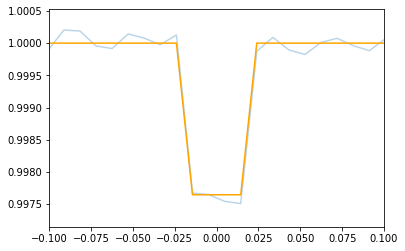

In [1583]:
plt.plot(time, nflux, alpha=0.3)
plt.plot(ttime, tfit, c='orange')
plt.xlim(-0.1, 0.1)

# plt.axvline(0-(T14n/86400)/2., color='b')
# plt.axvline(0+(T14n/86400)/2., color='b')

# plt.axvline(0-(T23n/86400)/2., color='r')
# plt.axvline(0+(T23n/86400)/2., color='r')


In [1584]:
gs_t, rhoc, rhoe, T14s, T23s = get_g_dist_synthetic(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
gs = gs_t

100%|██████████| 1000/1000 [00:00<00:00, 63803.34it/s]


In [1585]:
np.mean(gs)

0.9548373932917685

In [1542]:
#print(np.mean(rhoc))
#print(np.mean(rhoe))

In [1543]:
gs_sigmaminus, gs_sigmaplus = ph.get_sigmas(gs)
#print(gs_sigmaminus, gs_sigmaplus)

In [1544]:
def log_likelihood(theta, g, gerr):
    """Log of likelihood
    model = g(e,w)
    gerr = sigma of g distribution
    """
    w, e = theta
    model = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2 = gerr ** 2
    return -0.5 * np.sum((g - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    w, e = theta
    if 0.0 < e < 1.0 and -90.0 < w < 300.0:
        return 0.0
    return -np.inf

def log_probability(theta, g, gerr):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, g, gerr)

In [1545]:
#Guesses
w_guess = 0.0
e_guess = 0.35

In [1546]:
solnx = (w_guess, e_guess)

In [1547]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [1548]:
g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

In [1549]:
g_mean

1.2883998072668887

In [1550]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:07<00:00, 644.47it/s]


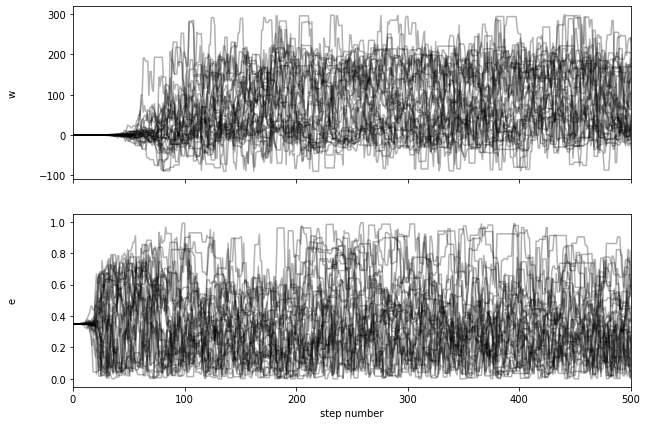

In [1551]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [1552]:
import corner

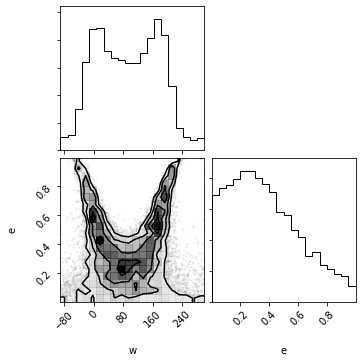

In [1553]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)